In [1]:
import os
import pandas as pd
import glob

import seaborn as sns
import matplotlib.pyplot as plt

import sys; sys.path.insert(0, "../utils/")
from data_utils import get_data_location, get_clinical_df, get_bluepoints_df, get_manual_severity_scores
from ml_pipeline import ModelEvaluation, highlight_max

DATA_PATH = get_data_location()

# Load data

In [2]:
pixel_count_path = os.path.join(DATA_PATH,"cropped_videos_segmented/post_processing")

# List all files & directories
files = os.listdir(pixel_count_path)

# keep only .csv files
csvs = [x for x in files if x.endswith(".gif_pixel_counts.csv")]

# Read all csvs into one dataframe
df = pd.concat((pd.read_csv(os.path.join(pixel_count_path, f)) for f in csvs))
df_orig = df.copy()

Add clinical data and bluepoint data

In [3]:
clinical_data = get_clinical_df()

clinical_data = clinical_data[["Video ID", "clin_diagn#COVID19_pneumonia"]]
clinical_data.columns = ["Patient ID", "COVID19"]

df = pd.merge(df_orig, clinical_data, on="Patient ID", how="left")

bp = get_bluepoints_df()

df = pd.merge(df, bp[["Bluepoint", "video_name"]], on="video_name", how="left")

severity_manual = get_manual_severity_scores()

# Rename Severity Score to manual_severity_score
severity_manual.rename(columns={"Severity Score": "manual_severity_score"}, inplace=True)

# Merge manual severity scores with yolo severity scores
df = df.merge(severity_manual[["video_name", "manual_severity_score"]], on="video_name", how="left")

Number of discarded rows: 8


In [4]:
# Plot number of discarded rows due to missing manual severity scores
print("Number of discarded frames due to missing manual severity scores: {}".format(len(df[df["manual_severity_score"].isna()])))

# Drop all rows where the manual severity score is not available
df = df.dropna(subset=["manual_severity_score"])


Number of discarded frames due to missing manual severity scores: 453


In [5]:
# Define class names
class_names = {"blue":"a-lines", "green":"few_b-lines", "orange":"more_b-lines", "red":"white_lung", "black":"nothing"}

# Rename columns blue, green, orange, red, black to class names
df = df.rename(columns=class_names)

In [ ]:
# The dataframe containes a row for each frame in all videos
# Columns:
#   Frame: Frame number in the video
#   blue, green, organge, red, black: Number of pixels in each color

df.head()

# Analysis

## Class area analysis

### Exploratory Plots

In [ ]:
video = "image_147549867609700"
video = df[df.video_name == video]

video_names = df.video_name.unique()

import random
# Set seed
random.seed(42)
random.shuffle(video_names)

# Example plots for different videos with number of pixels in each color. Frame number on x axis.

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, ax in enumerate(axs.flatten()):
    video = df[df.video_name == video_names[i]]
    
    sns.lineplot(data=video, x="Frame", y="a-lines", color="blue", ax=ax)
    sns.lineplot(data=video, x="Frame", y="few_b-lines", color="green", ax=ax)
    sns.lineplot(data=video, x="Frame", y="more_b-lines", color="orange", ax=ax)
    sns.lineplot(data=video, x="Frame", y="white_lung", color="red", ax=ax)
    # sns.lineplot(data=video, x="Frame", y="nothing", color="black", ax=ax)

    patient_id = video["Patient ID"].unique()[0]
    bp = video["Bluepoint"].unique()[0]
    covid = video["COVID19"].unique()[0]
    covid = "positive" if covid == 1 else "negative"
    ax.set_title(f"Patient: {patient_id}  Bluepoint: {bp} COVID19: {covid}")

# Rename y axis
# plt.ylabel("Number of pixels")

plt.show()


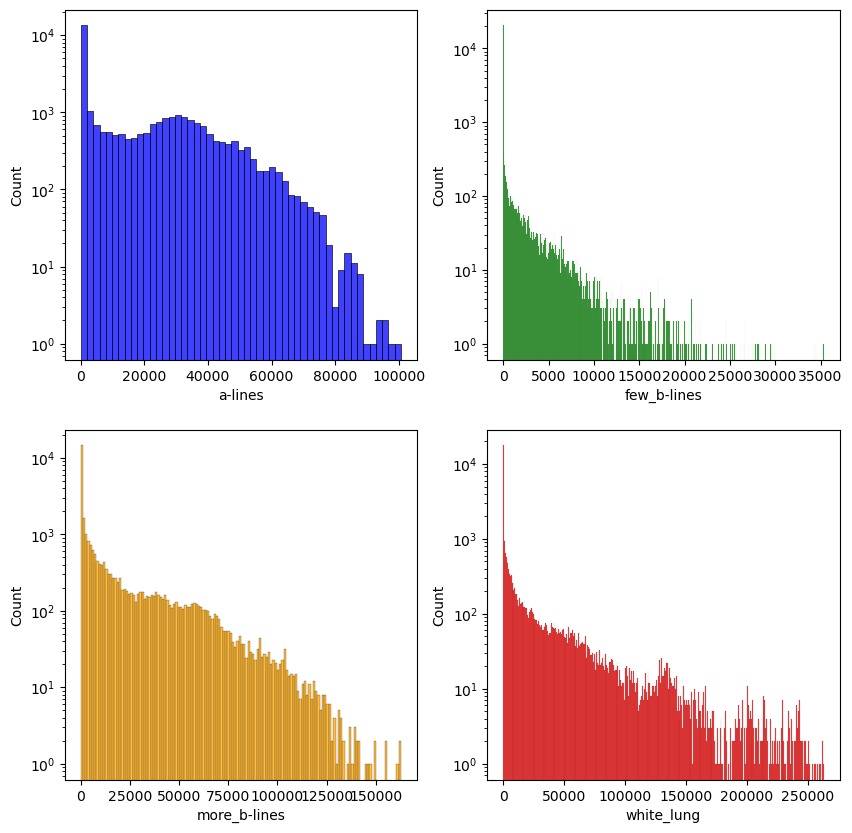

In [8]:
# Four subplots with histogram of the number of pixels in each color

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

sns.histplot(data=df, x="a-lines", color="blue", ax=axs[0, 0])
sns.histplot(data=df, x="few_b-lines", color="green", ax=axs[0, 1])
sns.histplot(data=df, x="more_b-lines", color="orange", ax=axs[1, 0])
sns.histplot(data=df, x="white_lung", color="red", ax=axs[1, 1])

# Set log scale on y axis
axs[0, 0].set_yscale("log")
axs[0, 1].set_yscale("log")
axs[1, 0].set_yscale("log")
axs[1, 1].set_yscale("log")


plt.show()

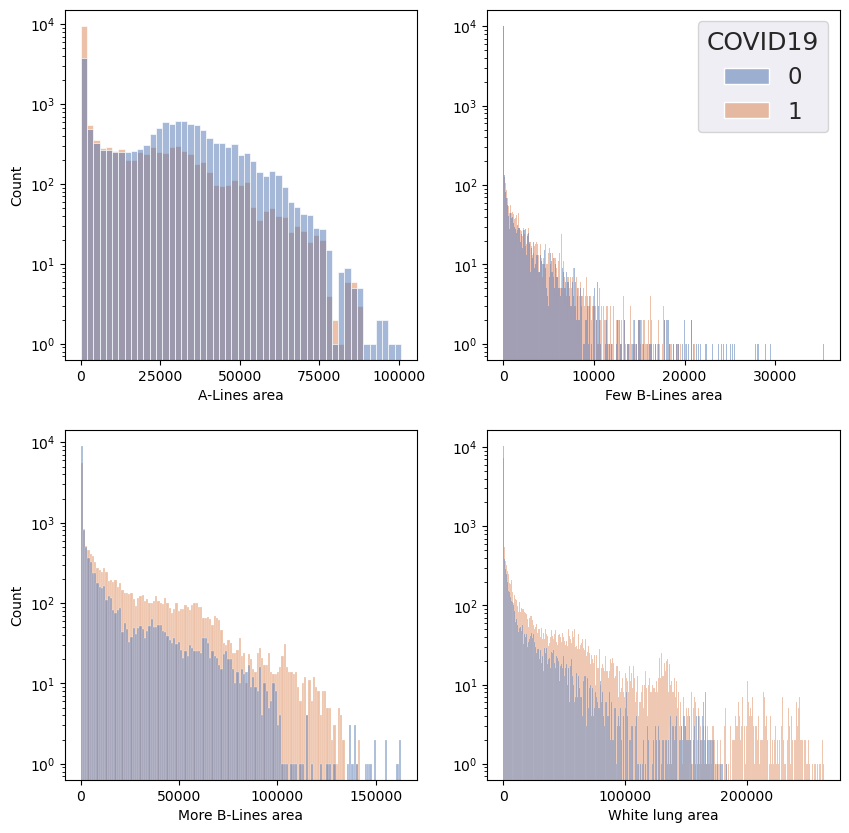

In [9]:
# Four subplots with histogram of the number of pixels in each color
# Color by covid19
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
sns.set(font_scale=1.5)

sns.histplot(data=df, x="a-lines", color="blue", hue="COVID19", ax=axs[0, 0]).set_xlabel("A-Lines area")
sns.histplot(data=df, x="few_b-lines", color="green", hue="COVID19", ax=axs[0, 1]).set_xlabel("Few B-Lines area")
sns.histplot(data=df, x="more_b-lines", color="orange", hue="COVID19", ax=axs[1, 0]).set_xlabel("More B-Lines area")
sns.histplot(data=df, x="white_lung", color="red", hue="COVID19", ax=axs[1, 1]).set_xlabel("White lung area")

# Set log scale on y axis
axs[0, 0].set_yscale("log")
axs[0, 1].set_yscale("log")
axs[1, 0].set_yscale("log")
axs[1, 1].set_yscale("log")

# Remove y axis label for every second plot
# axs[0, 0].set_ylabel("")
axs[0, 1].set_ylabel("")
# axs[1, 0].set_ylabel("")
axs[1, 1].set_ylabel("")

# Remove legend
axs[0, 0].legend_.remove()
# axs[0, 1].legend_.remove()
axs[1, 0].legend_.remove()
axs[1, 1].legend_.remove()

# Sup title
# fig.suptitle("Histogram of the number of pixels for each class separated by COVID-19", fontsize=20)

plt.show()

Visual inspection suggests that there is some kind of separation between the non-covid and the covid cases

Plot pathological vs non-pathological classes

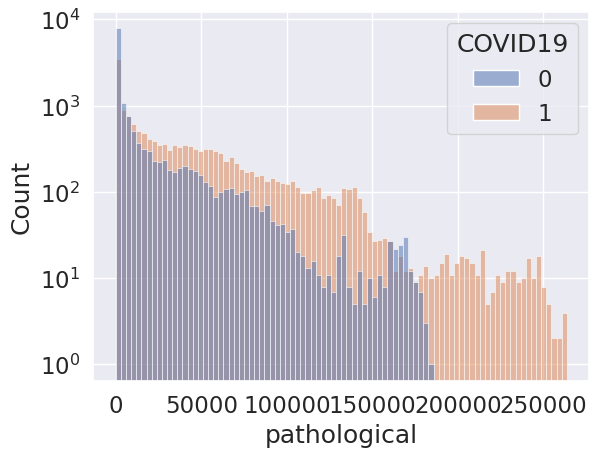

In [10]:
# Add column summing all b-lines and white lung as pathological features
df["pathological"] = df["few_b-lines"] + df["more_b-lines"] + df["white_lung"]

sns.histplot(data=df, x="pathological", hue="COVID19")
# Set log scale
plt.yscale("log")
plt.show()

In [11]:
from scipy.stats import mannwhitneyu


def mannwhitneyu_covid(df, column):

    x0 = df[df["COVID19"] == 0]
    x1 = df[df["COVID19"] == 1]

    x0 = x0[column]
    x1 = x1[column]

    # Mann-Whitney U-Test
    stat, p_value = mannwhitneyu(x0, x1)
    # print red if not significant green if significant
    if p_value > 0.05:
        print(f"\033[1;31m{column}: Statistic={stat:.4f}, p-value={p_value:.4f}\033[0m")
    else:
        print(f"\033[1;32m{column}: Statistic={stat:.4f}, p-value={p_value:.4f}\033[0m")

    return p_value

# Mann-Whitney U-Test for all colors
test_columns = ["a-lines", 
                "few_b-lines", 
                "more_b-lines", 
                "white_lung", 
                "nothing", 
                 "pathological",
                ]
p_values = []
for column in test_columns:
    p = mannwhitneyu_covid(df, column)
    p_values.append(p)


a-lines: Statistic=169507688.0000, p-value=0.0000
few_b-lines: Statistic=112684115.0000, p-value=0.0000
more_b-lines: Statistic=78349239.5000, p-value=0.0000
white_lung: Statistic=82187968.5000, p-value=0.0000
nothing: Statistic=133850687.5000, p-value=0.0000
pathological: Statistic=68828085.0000, p-value=0.0000


In [12]:
from statsmodels.sandbox.stats.multicomp import multipletests
p_adjusted = multipletests(p_values, method='bonferroni')
# print(f"p_adjusted: {p_adjusted[1]}")
for col in test_columns:
    # print red if not significant green if significant
    if p_adjusted[1][test_columns.index(col)] > 0.05:
        print(f"\033[1;31m{col}: p-value={p_adjusted[1][test_columns.index(col)]:.4f}\033[0m")
    else:
        print(f"\033[1;32m{col}: p-value={p_adjusted[1][test_columns.index(col)]:.4f}\033[0m")

a-lines: p-value=0.0000
few_b-lines: p-value=0.0000
more_b-lines: p-value=0.0000
white_lung: p-value=0.0000
nothing: p-value=0.0000
pathological: p-value=0.0000


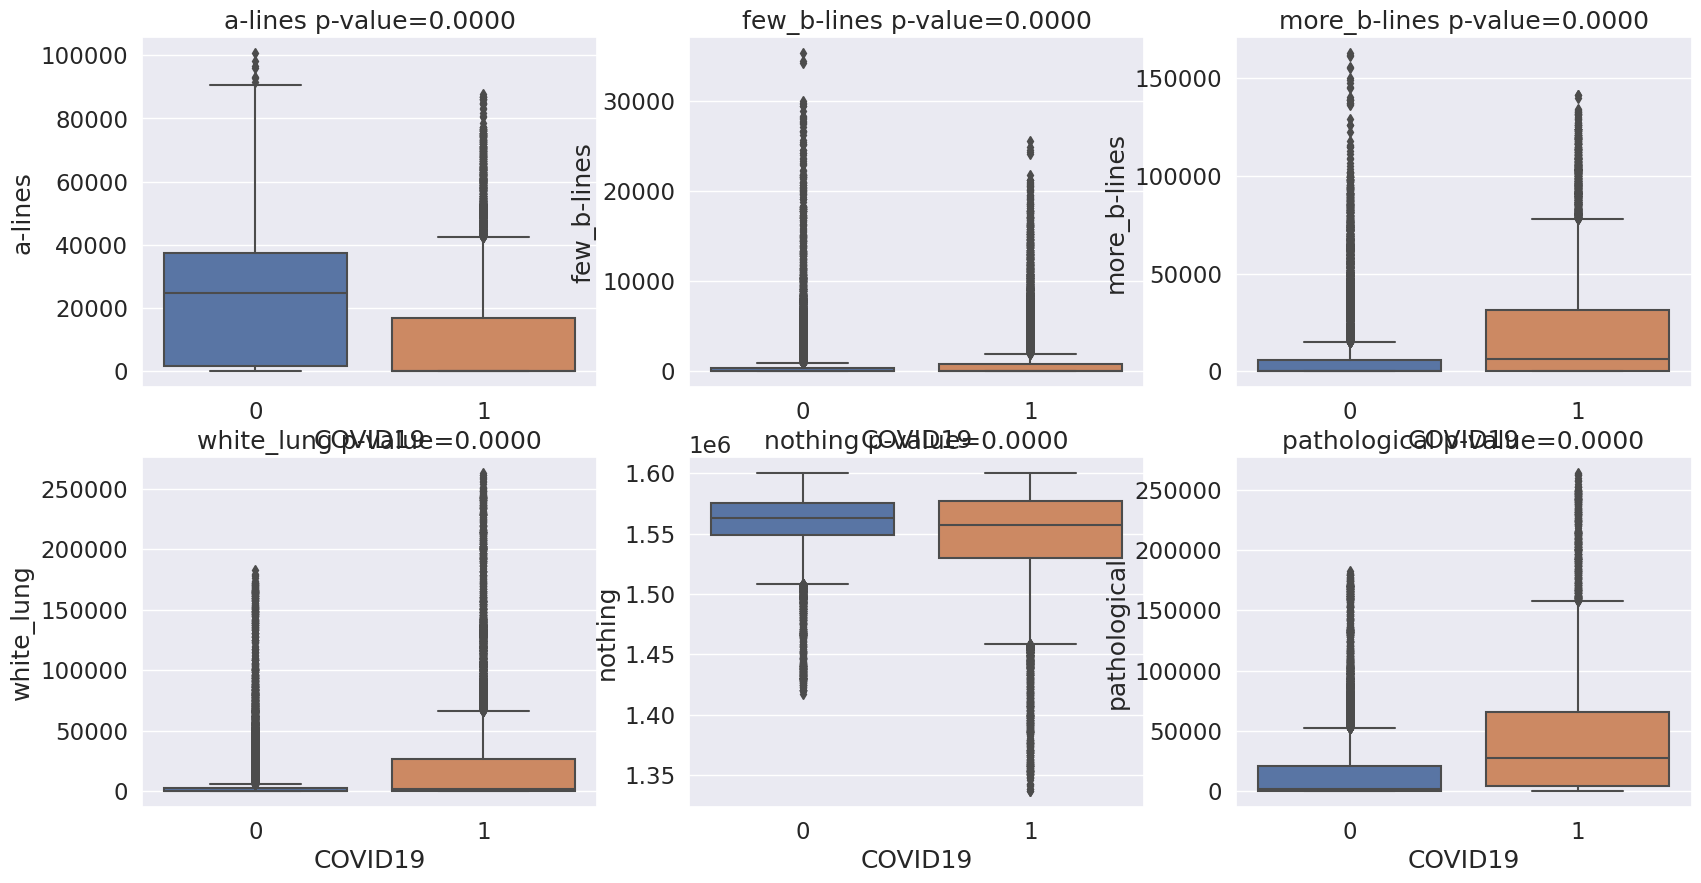

In [13]:
# Boxplot for each test_column
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, ax in enumerate(axs.flatten()):
    
    sns.boxplot(data=df, x="COVID19", y=test_columns[i], ax=ax)
    ax.set_title(f"{test_columns[i]} p-value={p_adjusted[1][i]:.4f}")

plt.show()

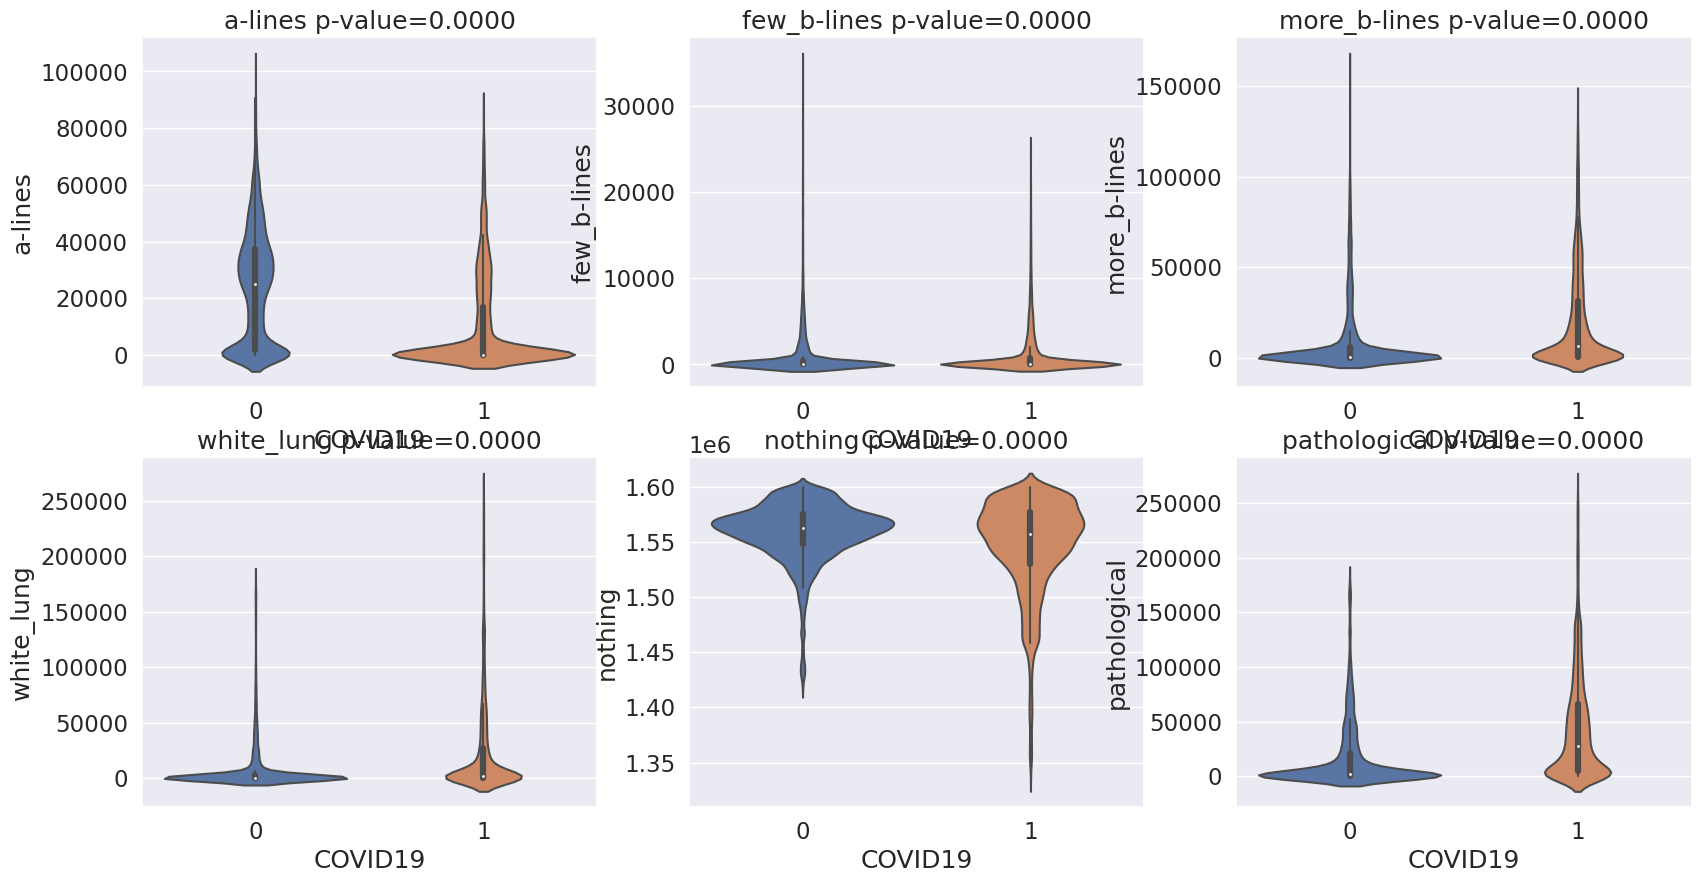

In [14]:
# Violin for each test_column
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, ax in enumerate(axs.flatten()):
    
    sns.violinplot(data=df, x="COVID19", y=test_columns[i], ax=ax)
    ax.set_title(f"{test_columns[i]} p-value={p_adjusted[1][i]:.4f}")

plt.show()

In [15]:
# Correlate all test_columns with each other and with COVID19
# Correlation matrix
corr = df[test_columns + ["COVID19"]].corr(method="spearman")
corr.style.background_gradient().format("{:.2f}")

,a-lines,few_b-lines,more_b-lines,white_lung,nothing,pathological,COVID19
a-lines,1.00,-0.11,-0.60,-0.51,-0.02,-0.70,-0.38
few_b-lines,-0.11,1.00,0.10,-0.02,0.23,0.14,0.05
more_b-lines,-0.60,0.10,1.00,0.44,-0.40,0.81,0.30
white_lung,-0.51,-0.02,0.44,1.00,-0.46,0.76,0.28
nothing,-0.02,0.23,-0.40,-0.46,1.00,-0.57,-0.11
pathological,-0.70,0.14,0.81,0.76,-0.57,1.00,0.36
COVID19,-0.38,0.05,0.30,0.28,-0.11,0.36,1.00


## Deducing severity score

In [ ]:
# For each class column determine whether a given frames contains more pixels than the 5% quantile of the class column
# We take the 5% quantile because we want to exclude small miss-classified regions but still have a high sensitivity

class_columns = ["a-lines", "few_b-lines", "more_b-lines", "white_lung"]

for column in class_columns:
    df[f"{column}_binary"] = 0
    df.loc[df[column] > df[column].quantile(0.20), f"{column}_binary"] = 1

# Calculate the severity score for each frame:
# If a frame contains no class or only a-lines, the severity score is 0
# If a frame contains few_b-lines, the severity score is 1
# If a frame contains more_b-lines, the severity score is 2
# If a frame contains white_lung, the severity score is 3

df["severity_score_deduced"] = 0
df.loc[df["few_b-lines_binary"] == 1, "severity_score_deduced"] = 1
df.loc[df["more_b-lines_binary"] == 1, "severity_score_deduced"] = 2
df.loc[df["white_lung_binary"] == 1, "severity_score_deduced"] = 3

df.head()

In [17]:
severity_comparison = df[["Patient ID", "video_name", "severity_score_deduced", "manual_severity_score", "COVID19"]]
# Drop duplicates
severity_comparison = severity_comparison.drop_duplicates()

In [18]:
from scipy.stats import spearmanr

#Calculate Spearman Rank correlation and corresponding p-value
rho, p = spearmanr(severity_comparison['severity_score_deduced'], severity_comparison['manual_severity_score'])

#Print Spearman rank correlation and p-value
print(f"Spearman Rank correlation: rho={rho:.4f}, p-value={p:.4f}")


Spearman Rank correlation: rho=0.1220, p-value=0.0006


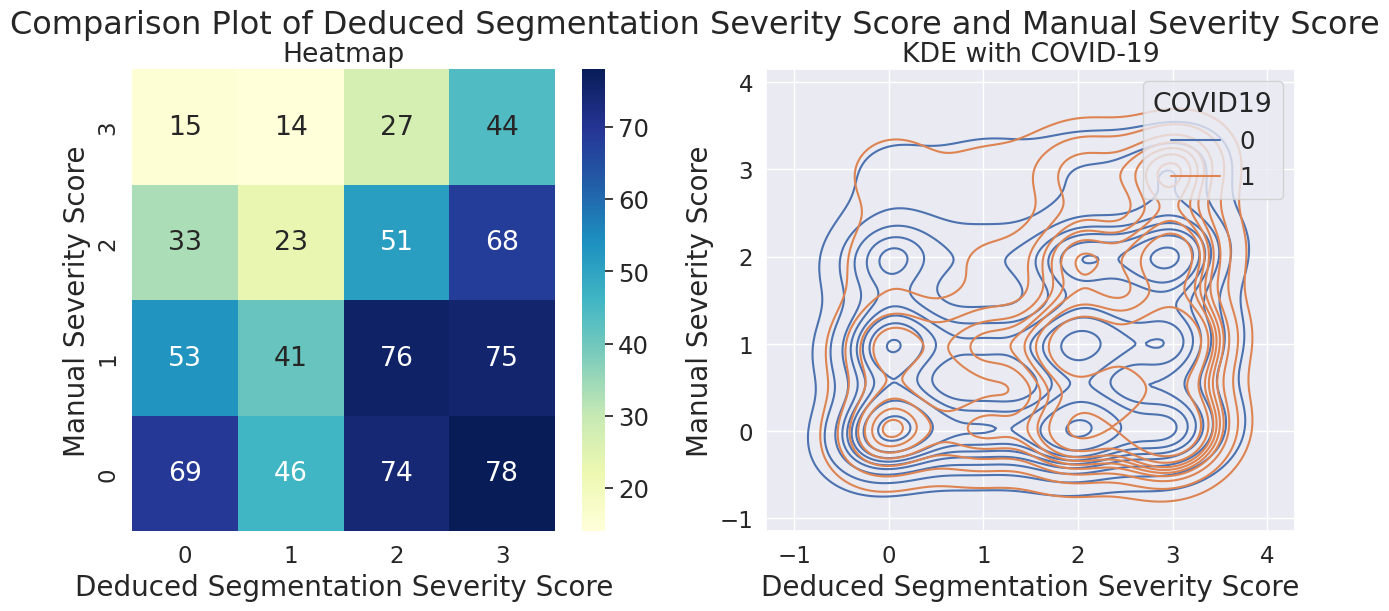

In [19]:
# Heatmap creation
pair_counts = severity_comparison[["severity_score_deduced", "manual_severity_score"]].value_counts().reset_index().rename(columns={0: "count"})
# Convert columns to int
pair_counts["severity_score_deduced"] = pair_counts["severity_score_deduced"].astype(int)
pair_counts["manual_severity_score"] = pair_counts["manual_severity_score"].astype(int)

pair_counts = pair_counts.pivot(index='manual_severity_score', columns='severity_score_deduced', values='count').fillna(0)
pair_counts = pair_counts.reindex(index=pair_counts.index[::-1])
# Convert all columns to int
for col in pair_counts.columns:
    pair_counts[col] = pair_counts[col].astype(int)


#Plot different views of the yolo severity score against the original severity score
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.set(font_scale=1.6)
# Heatmap
sns.heatmap(pair_counts, annot=True, cmap="YlGnBu", fmt="d", ax=axes[0]).set(title='Heatmap')

# KDE plot
#sns.kdeplot(x='severity_score_deduced', y='manual_severity_score', data=severity_comparison, shade=True, ax=axes[1]).set(title='KDE')
# KDE plot with covid
sns.kdeplot(x='severity_score_deduced', y='manual_severity_score', data=severity_comparison, hue='COVID19', ax=axes[1]).set(title='KDE with COVID-19')
for ax in axes:
    # set y axis label
    ax.set_ylabel('Manual Severity Score', fontsize=20)
    ax.set_xlabel('Deduced Segmentation Severity Score', fontsize=20)

plt.suptitle("Comparison Plot of Deduced Segmentation Severity Score and Manual Severity Score")
plt.show()



Bluepoint L1 has 5612 frames
Bluepoint L2 has 4789 frames
Bluepoint L3 has 4753 frames
Bluepoint R1 has 5562 frames
Bluepoint R2 has 5110 frames
Bluepoint R3 has 4906 frames


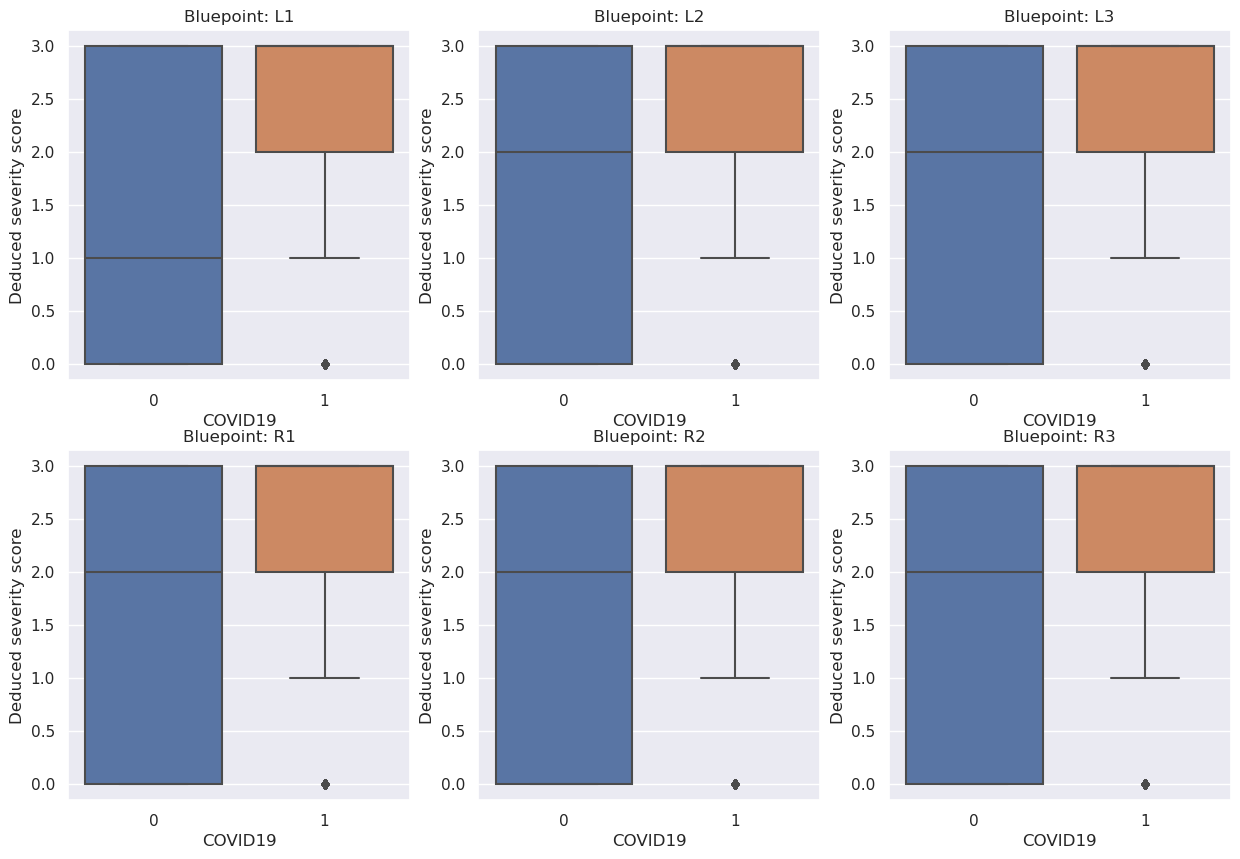

In [20]:
bluepoints =  ['L1', 'L2', 'L3', 'R1', 'R2', 'R3']

# Remove rows with Bluepoint Nan
df = df.dropna(subset=["Bluepoint"])

#set seaborn plotting aesthetics as default
sns.set()
#define plotting region 
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, bp in enumerate(bluepoints):
    # Filter the data
    bp_df = df[df.Bluepoint == bp]
    # Plot the data
    print(f"Bluepoint {bp} has {bp_df.shape[0]} frames")
    sns.boxplot(data=bp_df, x="COVID19", y="severity_score_deduced", ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f"Bluepoint: {bp}")
    axes[i//3, i%3].set_xlabel("COVID19")
    axes[i//3, i%3].set_ylabel("Deduced severity score")
    
plt.show()

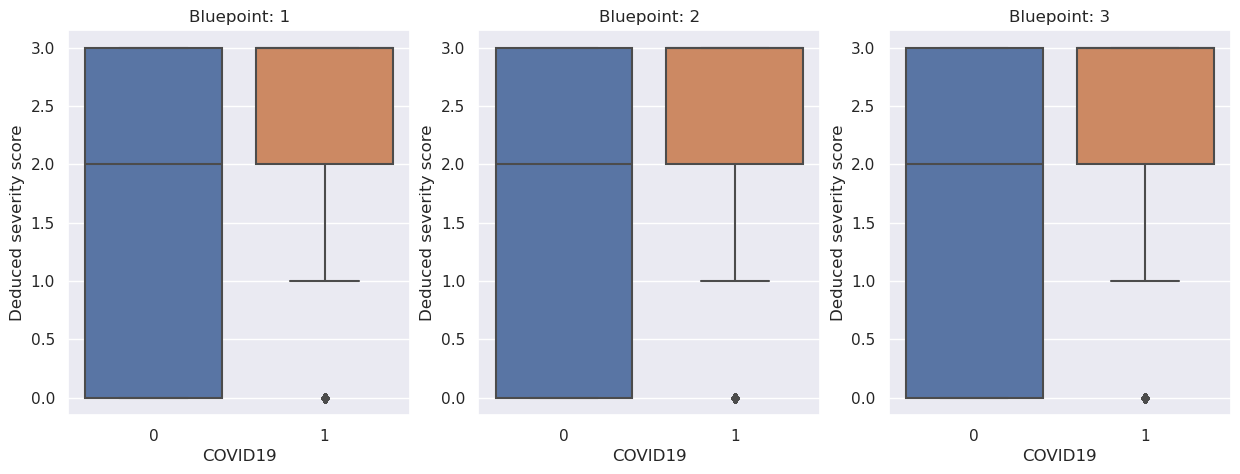

In [21]:
# Assigning L1 and R1 to the bilateral bluepoint "1", L2 and R2 to "2" and L3 and R3 to "3" for aggregated plotting
df["Bluepoint_bilateral"] = df["Bluepoint"].apply(lambda x: x[1])

# 3 subplots with scatter plot for each bluepoint BMI against std of severity score
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, bp in enumerate(["1", "2", "3"]):
    # Filter the data
    bp_df = df[df.Bluepoint_bilateral == bp]
    # Plot the data
    sns.boxplot(data=bp_df, x="COVID19", y="severity_score_deduced", ax=axes[i])
    axes[i].set_title(f"Bluepoint: {bp}")
    axes[i].set_xlabel("COVID19")
    axes[i].set_ylabel("Deduced severity score")

plt.show()

### Try different standard models using all class areas

In [22]:
# Group by video and sum all pixels
grp = df.groupby(["video_name"])
video_lvl = grp.agg({"a-lines": "mean", "few_b-lines": "mean", "more_b-lines": "mean", "white_lung": "mean", "nothing":"mean", "pathological":"mean", "COVID19":"first", "Bluepoint":"first", "Patient ID":"first", "video_name":"first"})

In [23]:
# from ml_pipeline import ModelEvaluation

Classifier = ModelEvaluation(mode="classification")

Train models on accumulated (mean) area of all detected classes:

In [24]:
# Class names don't include the "pathological" column
class_names = ["a-lines", "few_b-lines", "more_b-lines", "white_lung", "nothing"]

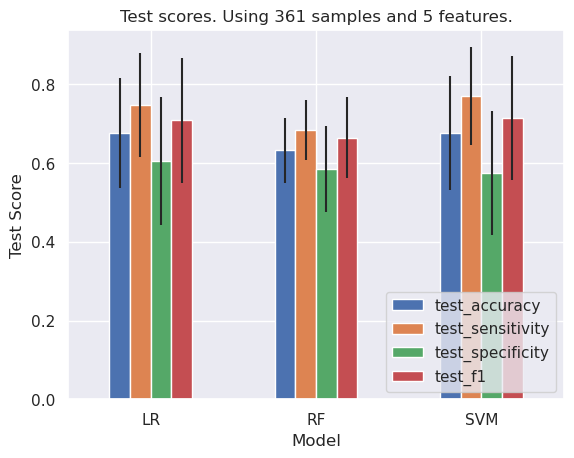

,test_accuracy,test_sensitivity,test_specificity,test_f1
model,,,,
LR,0.68,0.75,0.61,0.71
RF,0.63,0.68,0.58,0.66
SVM,0.68,0.77,0.57,0.71


In [25]:
# Shuffle
video_lvl = video_lvl.sample(frac=1, random_state=1).reset_index(drop=True)

# Split into X and y
X = video_lvl[class_names]
y = video_lvl["COVID19"]
groups = video_lvl["Patient ID"]

# Train models
scores, scores_mean, predictions, scores_std = Classifier.train_models(X, y, groups=groups, return_model_predictions=video_lvl, return_std=True)

# Save predictions df
predictions.to_csv("predictions_segmentation_class_area_video_lvl_COVID.csv")
# Load predictions df
# predictions = pd.read_csv("predictions_segmentation_class_area_video_lvl_COVID.csv", index_col=0)

scores_mean.style.apply(highlight_max).format("{:.2f}")

In [26]:
# Make latex table
scores_mean_latex = scores_mean.applymap(lambda x: f"{x:.2f}") + " $_{\pm " + scores_std.applymap(lambda x: f"{x:.2f}") + "}$"
scores_mean_latex = scores_mean_latex.to_latex(escape=False)
print(scores_mean_latex)

\begin{tabular}{lllll}
\toprule
{} &       test_accuracy &    test_sensitivity &    test_specificity &             test_f1 \\
model &                     &                     &                     &                     \\
\midrule
LR    &  0.68 $_{\pm 0.14}$ &  0.75 $_{\pm 0.13}$ &  0.61 $_{\pm 0.16}$ &  0.71 $_{\pm 0.16}$ \\
RF    &  0.63 $_{\pm 0.08}$ &  0.68 $_{\pm 0.08}$ &  0.58 $_{\pm 0.11}$ &  0.66 $_{\pm 0.10}$ \\
SVM   &  0.68 $_{\pm 0.14}$ &  0.77 $_{\pm 0.12}$ &  0.57 $_{\pm 0.16}$ &  0.71 $_{\pm 0.16}$ \\
\bottomrule
\end{tabular}



### Patient level area analysis

In [27]:
# Group by video and sum all pixels
grp = df.groupby(["Patient ID"])
patient_lvl = grp.agg({"a-lines": "mean", "few_b-lines": "mean", "more_b-lines": "mean", "white_lung": "mean", "nothing":"mean", "pathological":"mean", "COVID19":"first"})

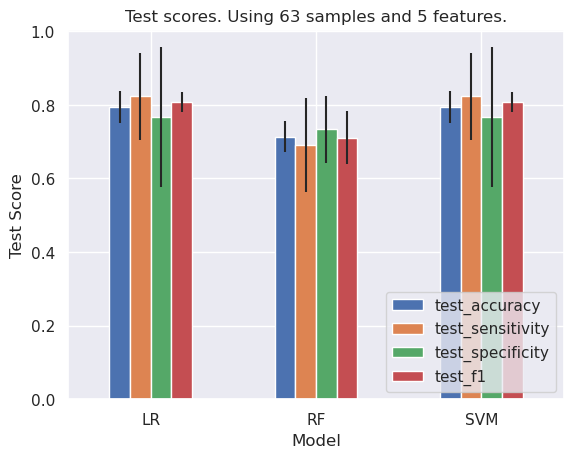

,test_accuracy,test_sensitivity,test_specificity,test_f1
model,,,,
LR,0.79,0.82,0.77,0.81
RF,0.71,0.69,0.73,0.71
SVM,0.79,0.82,0.77,0.81


In [28]:
# Shuffle
patient_lvl = patient_lvl.sample(frac=1, random_state=1).reset_index(drop=True)

# Split into X and y
X = patient_lvl[class_names]
y = patient_lvl["COVID19"]

# Train models
scores, scores_mean, scores_std = Classifier.train_models(X, y, return_std=True)

scores_mean.style.apply(highlight_max).format("{:.2f}")

In [29]:
# Make latex table
scores_mean_latex = scores_mean.applymap(lambda x: f"{x:.2f}") + " $_{\pm " + scores_std.applymap(lambda x: f"{x:.2f}") + "}$"
scores_mean_latex = scores_mean_latex.to_latex(escape=False)
print(scores_mean_latex)

\begin{tabular}{lllll}
\toprule
{} &       test_accuracy &    test_sensitivity &    test_specificity &             test_f1 \\
model &                     &                     &                     &                     \\
\midrule
LR    &  0.79 $_{\pm 0.04}$ &  0.82 $_{\pm 0.12}$ &  0.77 $_{\pm 0.19}$ &  0.81 $_{\pm 0.03}$ \\
RF    &  0.71 $_{\pm 0.04}$ &  0.69 $_{\pm 0.13}$ &  0.73 $_{\pm 0.09}$ &  0.71 $_{\pm 0.07}$ \\
SVM   &  0.79 $_{\pm 0.04}$ &  0.82 $_{\pm 0.12}$ &  0.77 $_{\pm 0.19}$ &  0.81 $_{\pm 0.03}$ \\
\bottomrule
\end{tabular}



The Patient level results seem quite promising even compared to the YOLO results (max 71%). Notworthy compared to the video level is that both sensitivity and specificity are similarly high on the patient level.

# Bluepoint analysis

In [30]:
bluepoints = df.Bluepoint.unique()
bluepoints = bluepoints[bluepoints != "None"]
# remove all nan values from list
bluepoints = [x for x in bluepoints if str(x) != 'nan']
# bluepoints.sort()
bluepoints

['R1', 'R2', 'R3', 'L1', 'L2', 'L3']

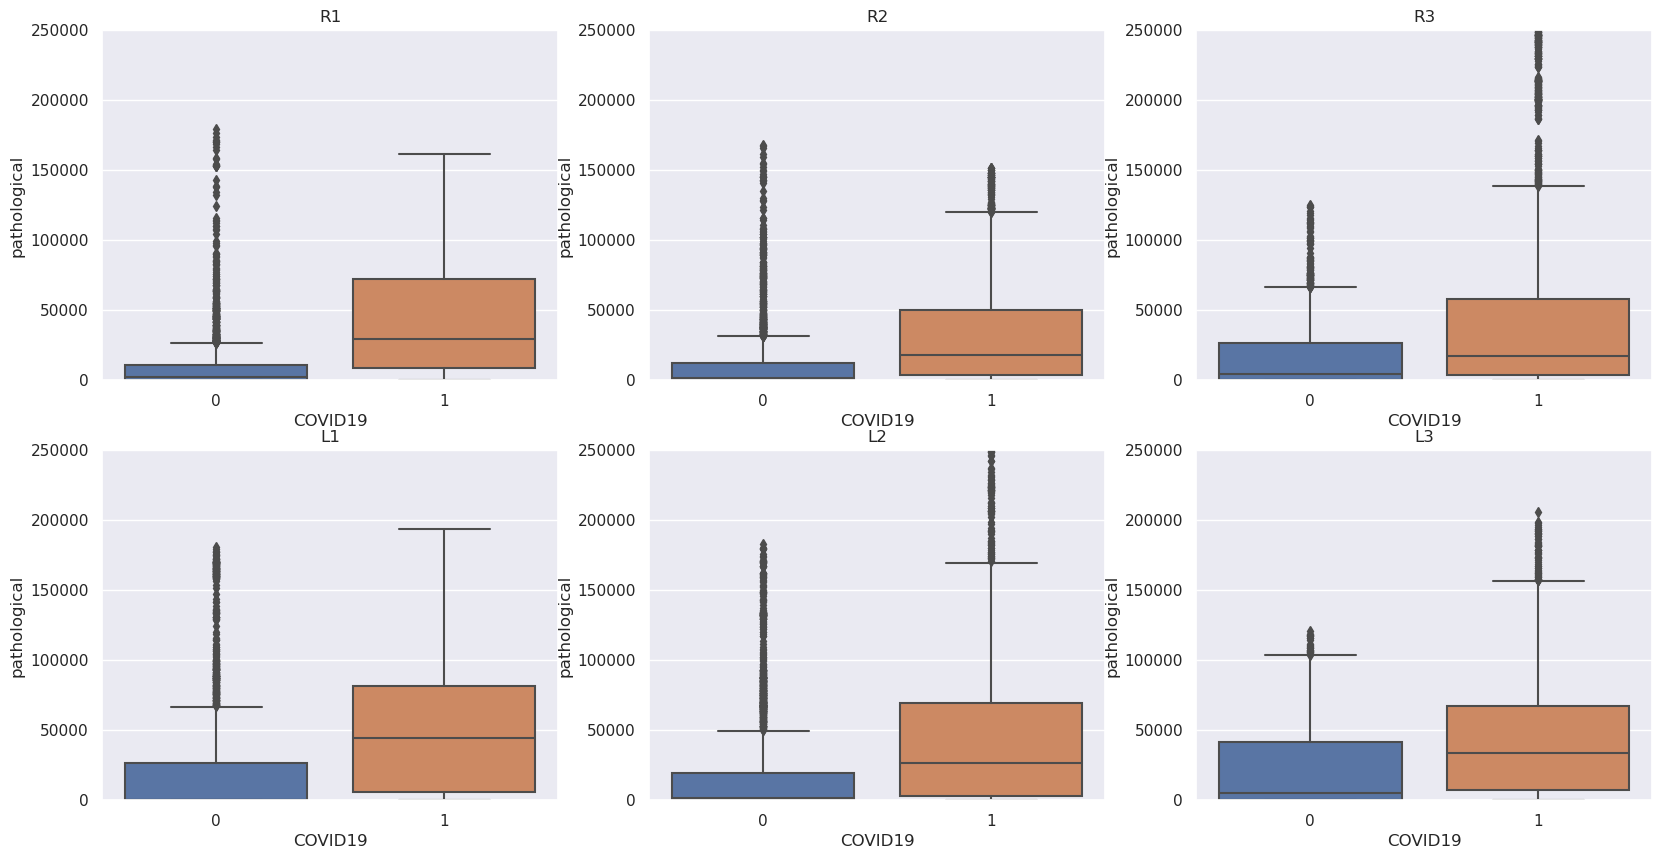

In [31]:
# Print pixel count for all bluepoints

# Boxplot for each test_column
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, ax in enumerate(axs.flatten()):
    bp = bluepoints[i]
    bp_df = df[df.Bluepoint == bp]
    sns.boxplot(data=bp_df, x="COVID19", y=test_columns[5], ax=ax)
    ax.set_title(f"{bp}")
    # Set y limits
    ax.set(ylim=(0,250000))


plt.show()

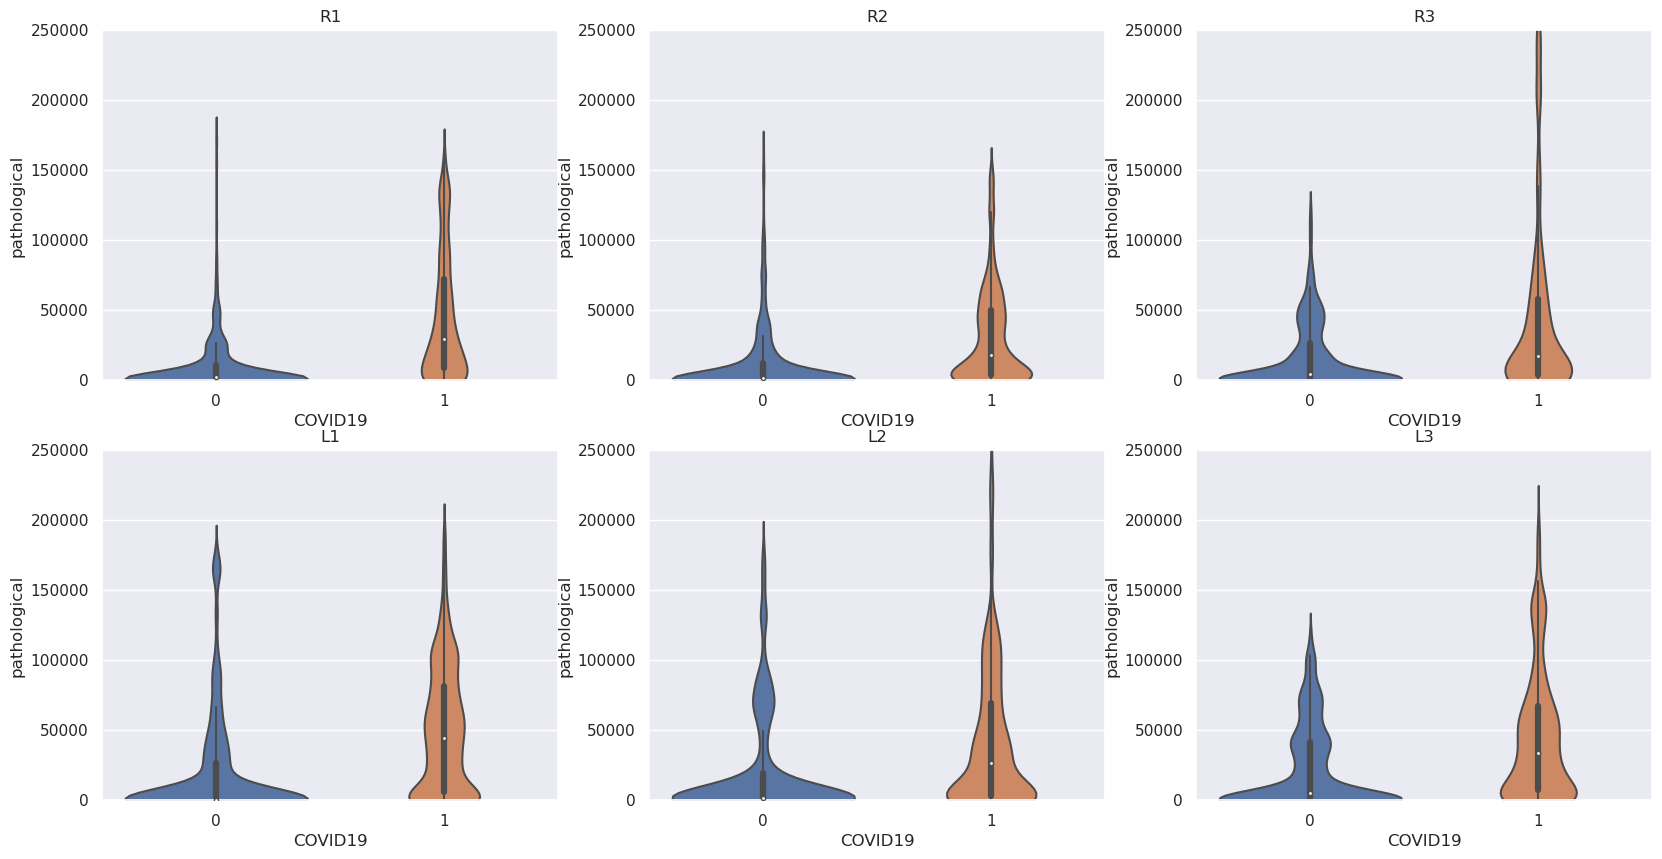

In [32]:
# Print pixel count for all bluepoints

# Boxplot for each test_column
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, ax in enumerate(axs.flatten()):
    bp = bluepoints[i]
    bp_df = df[df.Bluepoint == bp]
    sns.violinplot(data=bp_df, x="COVID19", y=test_columns[5], ax=ax)
    ax.set_title(f"{bp}")
    # Set y limits
    ax.set(ylim=(0,250000))


plt.show()

Visual inspection suggests that L/R1 has significantly more detected pathological features than L/R2 & 3

## Bluepoint information added to class area on video level

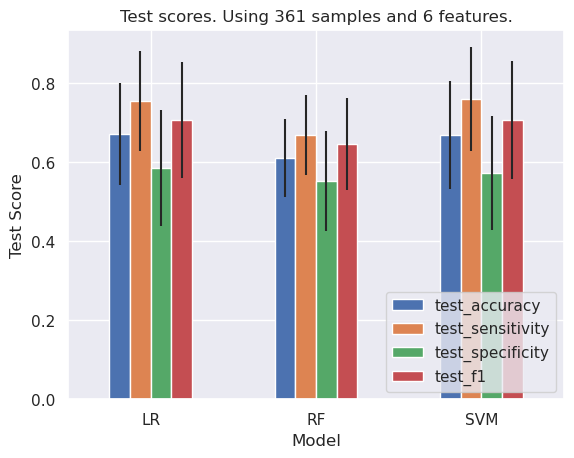

,test_accuracy,test_sensitivity,test_specificity,test_f1
model,,,,
LR,0.67,0.75,0.58,0.71
RF,0.61,0.67,0.55,0.65
SVM,0.67,0.76,0.57,0.71


In [33]:
# Filter out video with Bluepoint == None
video_lvl = video_lvl[video_lvl["Bluepoint"] != 'None']
video_lvl = video_lvl.dropna(subset=["Bluepoint"])

# Create a dictionary for mapping Bluepoint values to integers
bp2code = {bp: i for i, bp in enumerate(bluepoints)}
code2bp = {i: bp for i, bp in enumerate(bluepoints)}
# Map Bluepoint values to integers 
video_lvl["Bluepoint_codes"] = video_lvl["Bluepoint"].apply(lambda x: bp2code[x])

X = video_lvl[class_names + ["Bluepoint_codes"]]
y = video_lvl["COVID19"]
groups = video_lvl["Patient ID"]

scores, scores_mean = Classifier.train_models(X, y, groups=groups)
scores_mean.style.apply(highlight_max).format("{:.2f}")

Adding information about where the video was taken interestingly does not improve the performance compared to the model simply using all pathological classes.

### Training one model per Bluepoint

In [34]:
bluepoint_models = pd.DataFrame()
bluepoint_models_all = pd.DataFrame()
for bp in bluepoints:
    print(f"Training model for {bp}...")
    bp_df = video_lvl[video_lvl["Bluepoint"] == bp]
    X = bp_df[class_names]
    y = bp_df["COVID19"]

    scores, scores_mean = Classifier.train_models(X, y, plot=False)
    scores = pd.concat([scores], keys=[bp], names=['Bluepoint'])
    scores_mean = pd.concat([scores_mean], keys=[bp], names=['Bluepoint'])

    bluepoint_models_all = pd.concat([bluepoint_models_all, scores])
    bluepoint_models = pd.concat([bluepoint_models, scores_mean])


bluepoint_models.style.apply(highlight_max).format("{:.2f}")

Training model for R1...
Training model for R2...
Training model for R3...
Training model for L1...
Training model for L2...
Training model for L3...


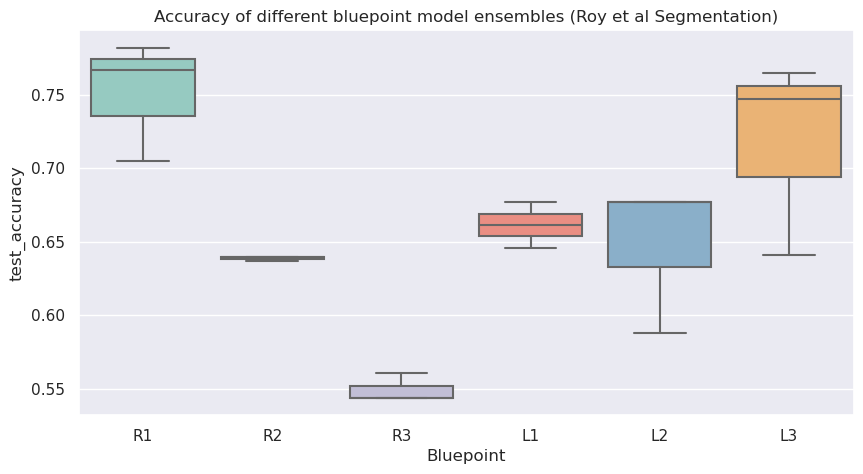

In [35]:
bluepoint_models = bluepoint_models.reset_index()

plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=bluepoint_models, x="Bluepoint", y="test_accuracy", palette="Set3")
plt.title("Accuracy of different bluepoint model ensembles (Roy et al Segmentation)")
plt.show()

/tmp/ipykernel_19473/2640749674.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


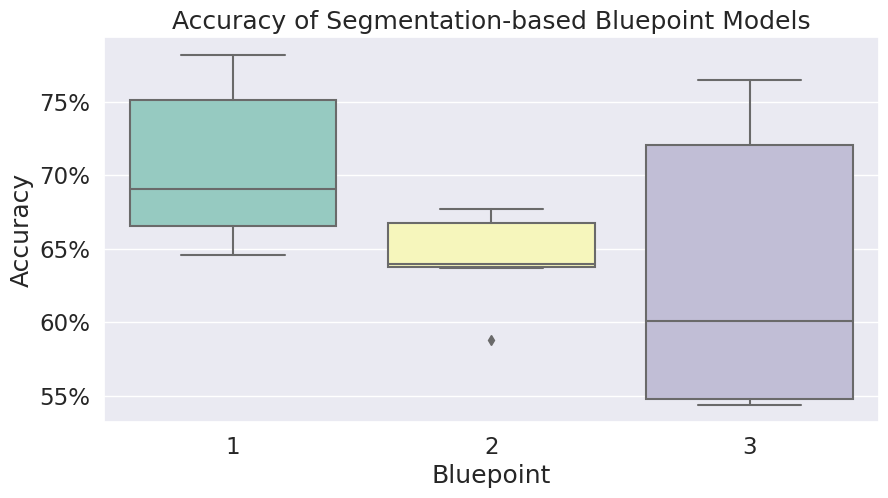

In [36]:
from statannot import add_stat_annotation

# Assigning L1 and R1 to the bilateral bluepoint "1", L2 and R2 to "2" and L3 and R3 to "3" for aggregated plotting
bluepoint_models["Bluepoint_bilateral"] = bluepoint_models["Bluepoint"].apply(lambda x: x[1])

pairs = [('1', '2'),
        ('1', '3'),
        ('2', '3'),
        ]

plt.figure(figsize=(10, 5))
sns.set(font_scale=1.5)
ax = sns.boxplot(data=bluepoint_models, x="Bluepoint_bilateral", y="test_accuracy", palette="Set3")
ax.set_xlabel("Bluepoint")
ax.set_ylabel("Accuracy")
# Display y ticks as percentage
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
# add_stat_annotation(ax, data=bluepoint_models, x="Bluepoint_bilateral", y="test_accuracy",
#                     box_pairs=pairs,
#                     test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
plt.title("Accuracy of Segmentation-based Bluepoint Models")
plt.show()

In [37]:
bp_left = bluepoint_models_all.loc[["L1", "L2", "L3"]].test_accuracy
bp_right = bluepoint_models_all.loc[["R1", "R2", "R3"]].test_accuracy

bp_1 = bluepoint_models_all.loc[["L1", "R1"]].test_accuracy
bp_2 = bluepoint_models_all.loc[["L2", "R2"]].test_accuracy
bp_3 = bluepoint_models_all.loc[["L3", "R3"]].test_accuracy

p_values = []

# Mann-Whitney U-Test
# stat, p_value = mannwhitneyu(bp_left, bp_right)
# p_values.append(p_value)
# print("Bluepoint left vs right")
# print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
# print(f"Mean accuracy left: {bp_left.mean():.4f}")
# print(f"Mean accuracy right: {bp_right.mean():.4f}")

print("Bluepoint 1 vs 2 vs 3")
print("1 vs 2")
stat, p_value = mannwhitneyu(bp_1, bp_2)
p_values.append(p_value)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print("2 vs 3")
stat, p_value = mannwhitneyu(bp_2, bp_3)
p_values.append(p_value)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print("1 vs 3")
stat, p_value = mannwhitneyu(bp_1, bp_3)
p_values.append(p_value)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n Means:")
print(f"Mean accuracy 1: {bp_1.mean():.4f}")
print(f"Mean accuracy 2: {bp_2.mean():.4f}")
print(f"Mean accuracy 3: {bp_3.mean():.4f}")

Bluepoint 1 vs 2 vs 3
1 vs 2
Mann–Whitney U Test: statistic=598.5000, p-value=0.0280
2 vs 3
Mann–Whitney U Test: statistic=445.5000, p-value=0.9526
1 vs 3
Mann–Whitney U Test: statistic=578.0000, p-value=0.0585

 Means:
Mean accuracy 1: 0.7064
Mean accuracy 2: 0.6432
Mean accuracy 3: 0.6336


In [38]:
# Using bonferonni correction for multiple comparisons
from statsmodels.sandbox.stats.multicomp import multipletests
p_adjusted = multipletests(p_values, method='bonferroni')

print("Bonferroni corrected p-values:")

test_distributions = [#"L vs R", 
                    "1 vs 2", 
                    "2 vs 3", 
                    "1 vs 3"]
# Print green if p-value is significant otherwise red
for i, p in enumerate(p_adjusted[1]):
    if p < 0.05:
        print(f"\033[92m{test_distributions[i]}: {p:.4f}\033[0m")
    else:
        print(f"\033[91m{test_distributions[i]}: {p:.4f}\033[0m")


Bonferroni corrected p-values:
1 vs 2: 0.0839
2 vs 3: 1.0000
1 vs 3: 0.1756


### Add manual severity labels

In [39]:
# severity_manual = get_manual_severity_scores()

# # Merge manual severity scores with yolo severity scores
# df = df.merge(severity_manual[["video_name", "Severity Score"]], on="video_name", how="left")

# # Rename Severity Score to manual_severity_score
# df.rename(columns={"Severity Score": "manual_severity_score"}, inplace=True)

In [40]:
# Drop rows with missing severity scores
severity_comparison = df[~df["manual_severity_score"].isna()]

In [41]:
# Omitt "nothing" & "pathological" from class_names
class_names = ["a-lines", "few_b-lines", "more_b-lines", "white_lung", 
# "nothing", 
# "pathological"
]


#### Frame level

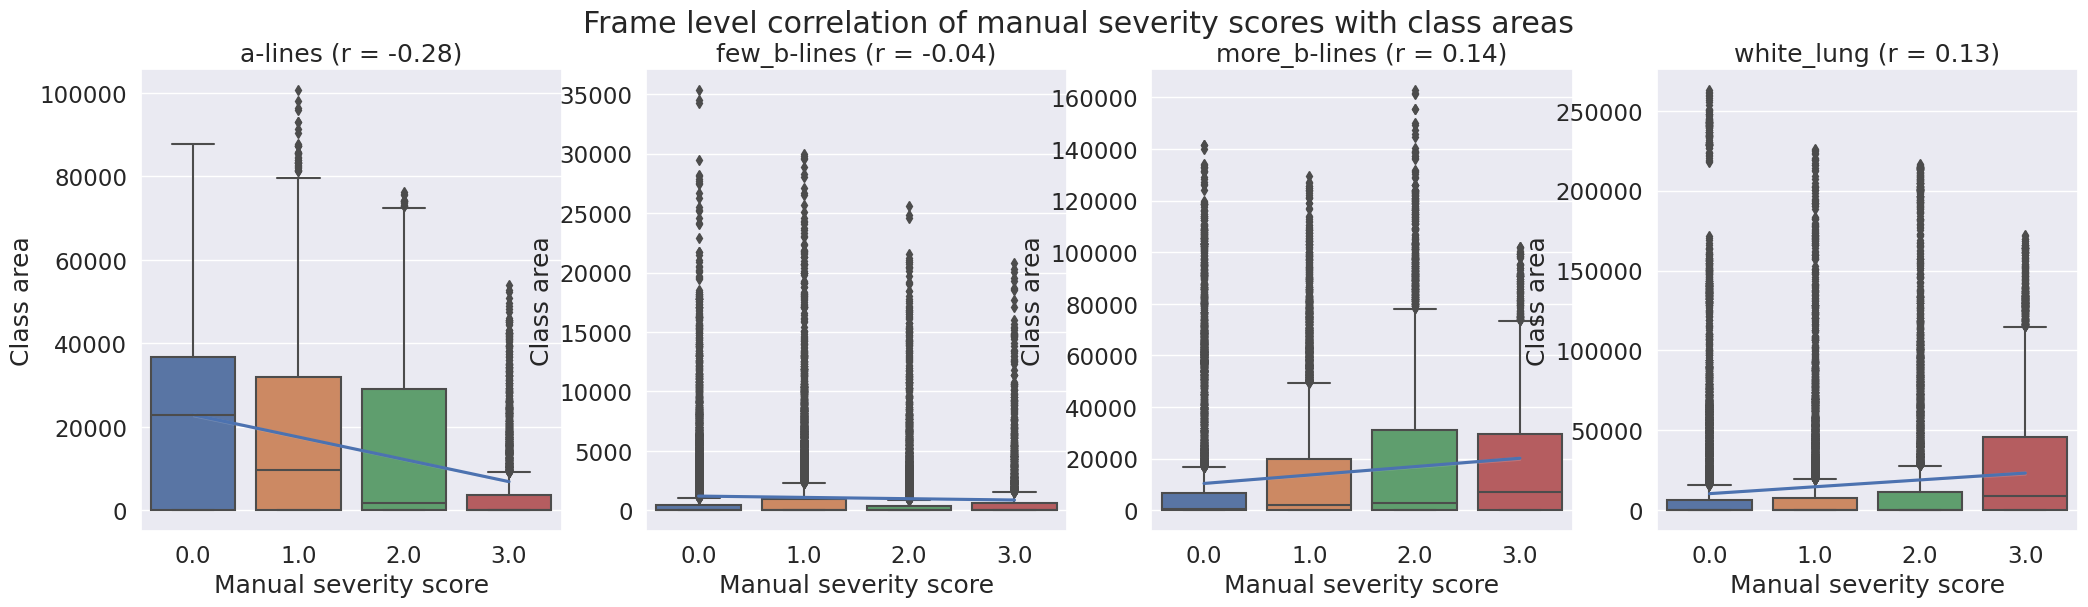

In [42]:
# Plot and correlate manual severity scores with class areas
# Boxplot for each test_column
fig, axs = plt.subplots(1, len(class_names), figsize=(25, 6))

for i, ax in enumerate(axs.flatten()):
    cl = class_names[i]
    sns.boxplot(data=severity_comparison, y=cl, x="manual_severity_score", ax=ax)
    # Add regression line to plot
    sns.regplot(data=severity_comparison, y=cl, x="manual_severity_score", ax=ax, scatter=False)
    corr = severity_comparison.manual_severity_score.corr(severity_comparison[cl])
    ax.set_title(f"{cl} (r = {corr:.2f})")
    ax.set_xlabel("Manual severity score")
    ax.set_ylabel("Class area")

plt.suptitle("Frame level correlation of manual severity scores with class areas")
plt.show()

#### Video level

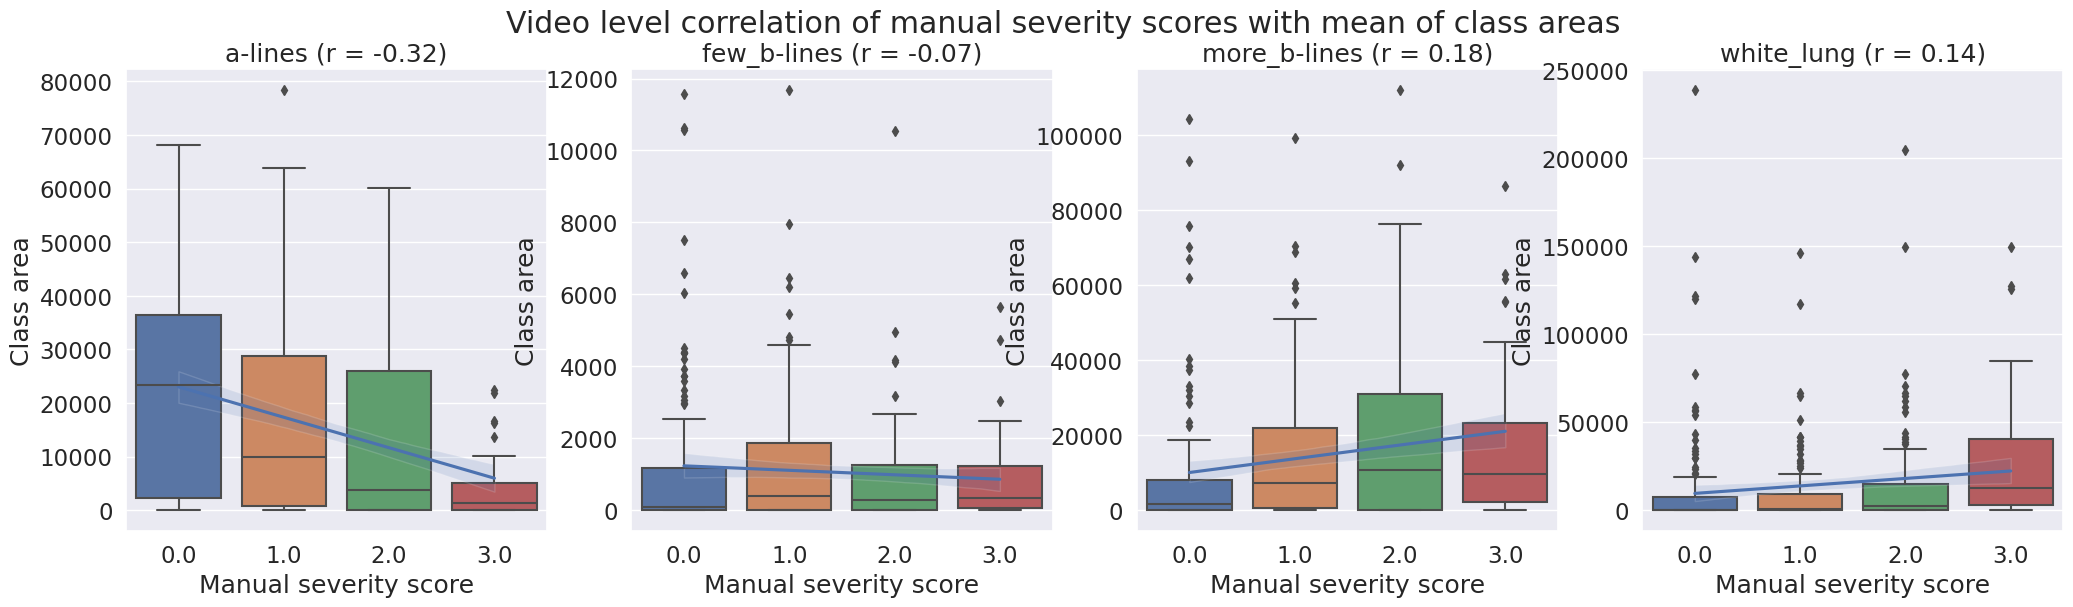

In [43]:
# Group by video and sum all pixels
grp = severity_comparison.groupby(["video_name"])
video_lvl_mean = grp.agg({"a-lines": "mean", "few_b-lines": "mean", "more_b-lines": "mean", "white_lung": "mean", "nothing":"mean", "pathological":"mean", "manual_severity_score":"first"})

# Plot and correlate manual severity scores with class areas
# Boxplot for each test_column
fig, axs = plt.subplots(1, len(class_names), figsize=(25, 6))

for i, ax in enumerate(axs.flatten()):
    cl = class_names[i]
    sns.boxplot(data=video_lvl_mean, y=cl, x="manual_severity_score", ax=ax)
    # Add regression line to plot
    sns.regplot(data=video_lvl_mean, y=cl, x="manual_severity_score", ax=ax, scatter=False)
    corr = video_lvl_mean.manual_severity_score.corr(video_lvl_mean[cl])
    ax.set_title(f"{cl} (r = {corr:.2f})")
    ax.set_xlabel("Manual severity score")
    ax.set_ylabel("Class area")

plt.suptitle("Video level correlation of manual severity scores with mean of class areas")
plt.show()

#### Patient level

/tmp/ipykernel_19473/1104944854.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{y/1000:.0f}k" for y in ax.get_yticks()])
/tmp/ipykernel_19473/1104944854.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{y/1000:.0f}k" for y in ax.get_yticks()])
/tmp/ipykernel_19473/1104944854.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{y/1000:.0f}k" for y in ax.get_yticks()])
/tmp/ipykernel_19473/1104944854.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{y/1000:.0f}k" for y in ax.get_yticks()])


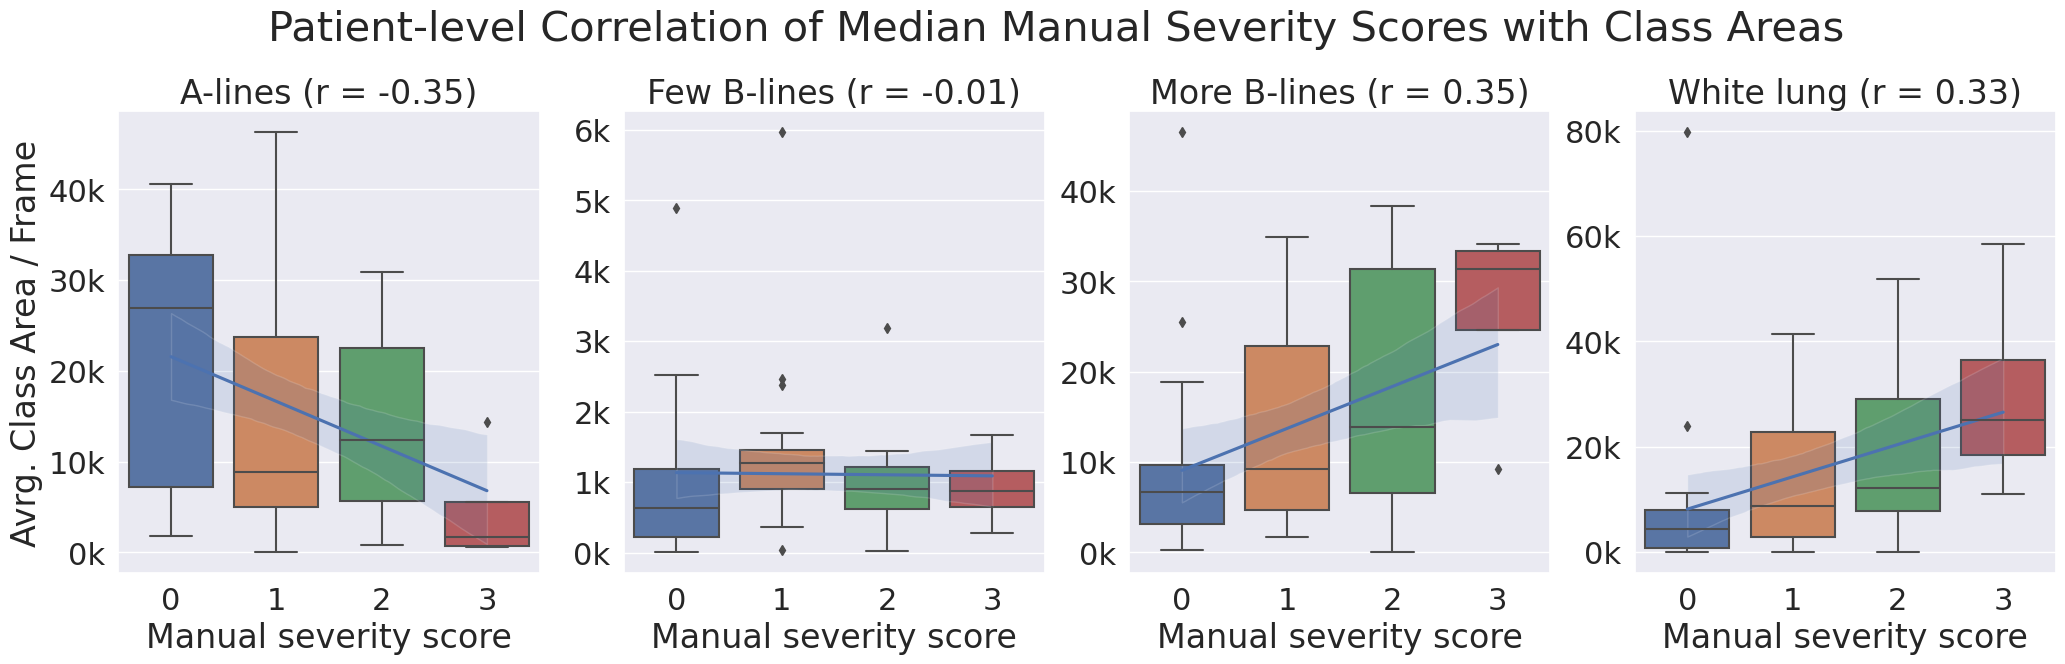

In [44]:
# Group by video and sum all pixels
# grp = severity_comparison.groupby(["Patient ID"])
# patient_level = grp.agg({"a-lines": "mean", "few_b-lines": "mean", "more_b-lines": "mean", "white_lung": "mean", "nothing":"mean", "pathological":"mean", "manual_severity_score":"median"})

# Group by video and sum all pixels
grp = severity_comparison.groupby(["Patient ID"])
agg_dict = {cl: "mean" for cl in class_names}
agg_dict["manual_severity_score"] = "median"
patient_level = grp.agg(agg_dict).reset_index()
# manual_severity_score as int
patient_level["manual_severity_score"] = patient_level["manual_severity_score"].astype(int)
# Rename class name columns
clann_names_renamed = ["A-lines", "Few B-lines", "More B-lines", "White lung"]
patient_level.rename(columns={"a-lines": "A-lines", "few_b-lines": "Few B-lines", "more_b-lines": "More B-lines", "white_lung": "White lung"}, inplace=True)



# Plot and correlate manual severity scores with class areas
sns.set(font_scale=2)
# Boxplot for each test_column
fig, axs = plt.subplots(1, len(class_names), figsize=(25, 6))

for i, ax in enumerate(axs.flatten()):
    cl = clann_names_renamed[i]
    sns.boxplot(data=patient_level, y=cl, x="manual_severity_score", ax=ax)
    # Add regression line to plot
    sns.regplot(data=patient_level, y=cl, x="manual_severity_score", ax=ax, scatter=False)   
    corr = patient_level.manual_severity_score.corr(patient_level[cl])
    ax.set_title(f"{cl} (r = {corr:.2f})")
    ax.set_xlabel("Manual severity score")
    if i == 0:
        ax.set_ylabel("Avrg. Class Area / Frame")
    else:
        ax.set_ylabel("")
    # Y ticks as k
    ax.set_yticklabels([f"{y/1000:.0f}k" for y in ax.get_yticks()])

plt.suptitle("Patient-level Correlation of Median Manual Severity Scores with Class Areas", fontsize=30, y=1.05)
plt.show()

## Predicting the severity score using the class volume

In [45]:
import importlib
import ml_pipeline
importlib.reload(ml_pipeline)
from ml_pipeline import ModelEvaluation


Regressor = ModelEvaluation(mode="regression")

### Video Level

In [46]:
# Group by video and sum all pixels
grp = df.groupby(["video_name"])
video_lvl = grp.agg({"a-lines": "mean", "few_b-lines": "mean", "more_b-lines": "mean", "white_lung": "mean", "nothing":"mean", "pathological":"mean", "COVID19":"first", "Bluepoint":"first", "Patient ID":"first", "manual_severity_score":"first", "video_name":"first"})

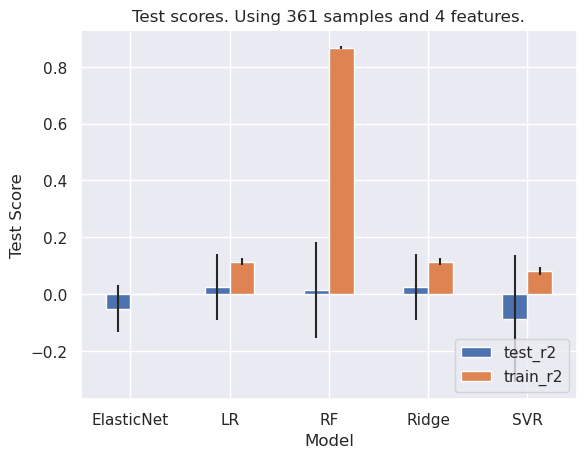

,test_r2,train_r2
model,,
ElasticNet,-0.05,0.00
LR,0.02,0.11
RF,0.01,0.87
Ridge,0.02,0.11
SVR,-0.09,0.08


In [47]:
# Shuffle
video_lvl = video_lvl.sample(frac=1, random_state=1).reset_index(drop=True)
video_lvl = video_lvl.dropna(subset=["manual_severity_score"])

# Split into X and y
X = video_lvl[class_names]
y = video_lvl["manual_severity_score"]
groups = video_lvl["Patient ID"]

# Train models
scores, scores_mean, predictions = Regressor.train_models(X, y, groups=groups, return_train_scores=True, return_model_predictions=video_lvl)

scores_mean.style.apply(highlight_max).format("{:.2f}")

Try if classification task works better

In [68]:
import importlib
import ml_pipeline
importlib.reload(ml_pipeline)
from ml_pipeline import ModelEvaluation


Classifier = ModelEvaluation(mode="classification_multi_label")

/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scr

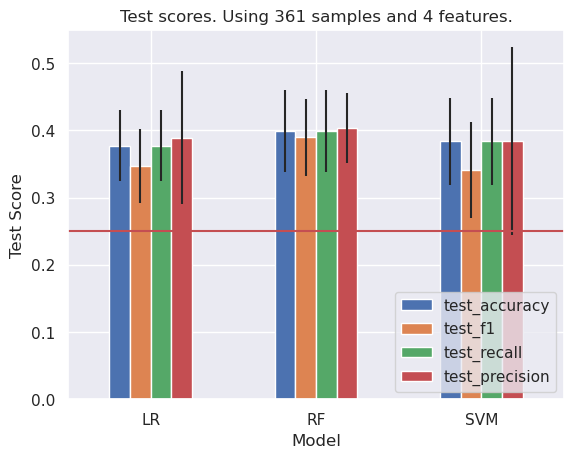

,test_accuracy,test_f1,test_recall,test_precision
model,,,,
LR,0.38,0.35,0.38,0.39
RF,0.40,0.39,0.40,0.40
SVM,0.38,0.34,0.38,0.38


In [69]:
# Shuffle
video_lvl = video_lvl.sample(frac=1, random_state=1).reset_index(drop=True)
video_lvl = video_lvl.dropna(subset=["manual_severity_score"])

# Split into X and y
X = video_lvl[class_names]
y = video_lvl["manual_severity_score"]
groups = video_lvl["Patient ID"]

# Train models
scores, scores_mean, predictions, scores_std = Classifier.train_models(X, y, groups=groups, 
                                            # return_train_scores=True,
                                            return_model_predictions=video_lvl,
                                            return_std=True,
                                            )

scores_mean.style.apply(highlight_max).format("{:.2f}")

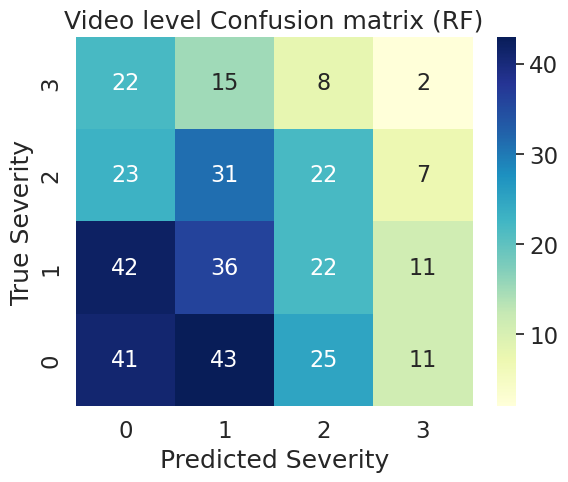

In [70]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_pred = predictions["RF"].values
y_true = y.values

# Get confusion matrix
cm = confusion_matrix(y_true, y_pred)
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(cm, range(4), range(4))
# Flipping y axis
df_cm_video = df_cm.iloc[::-1]
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.5) # for label size
sns.heatmap(df_cm_video, annot=True, annot_kws={"size": 16}, cmap="YlGnBu", fmt="d").set(xlabel="Predicted Severity", ylabel="True Severity", title="Video level Confusion matrix (RF)")

plt.show()


/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


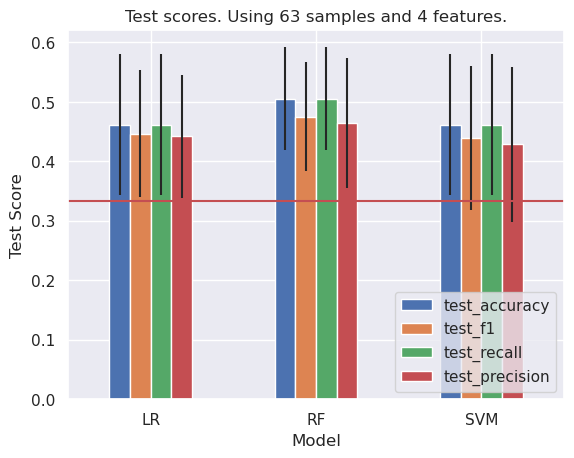

,test_accuracy,test_f1,test_recall,test_precision
model,,,,
LR,0.46,0.45,0.46,0.44
RF,0.51,0.48,0.51,0.46
SVM,0.46,0.44,0.46,0.43


In [71]:
# Group by video and sum all pixels
grp = df.groupby(["Patient ID"])
patient_lvl = grp.agg({"a-lines": "mean", 
                    "few_b-lines": "mean", 
                    "more_b-lines": "mean", 
                    "white_lung": "mean", 
                    "nothing":"mean", 
                    "pathological":"mean", 
                    "COVID19":"first", 
                    "manual_severity_score": "mean"})

# Shuffle
patient_lvl = patient_lvl.sample(frac=1, random_state=1).reset_index(drop=True)
patient_lvl = patient_lvl.dropna(subset=["manual_severity_score"])
# Round up the manual severity score to ints
patient_lvl["manual_severity_score"] = patient_lvl["manual_severity_score"].astype(int)

# Split into X and y
X = patient_lvl[class_names]
y = patient_lvl["manual_severity_score"]

# Train models
scores_patient, scores_mean_patient, scores_std_patient = Classifier.train_models(X, y, 
                            # return_train_scores=True
                            return_std=True
                            )

scores_mean_patient.style.apply(highlight_max).format("{:.2f}")

In [72]:
y.value_counts()

0    29
1    23
2    11
Name: manual_severity_score, dtype: int64

Does not improve on patient level.
Caveat: Only four patients with a severity score of 3. This might be too few to train a model on.

,test_accuracy,test_f1,test_recall,test_precision
Patient (RF),0.51,0.48,0.51,0.46
Video (RF),0.40,0.39,0.40,0.40


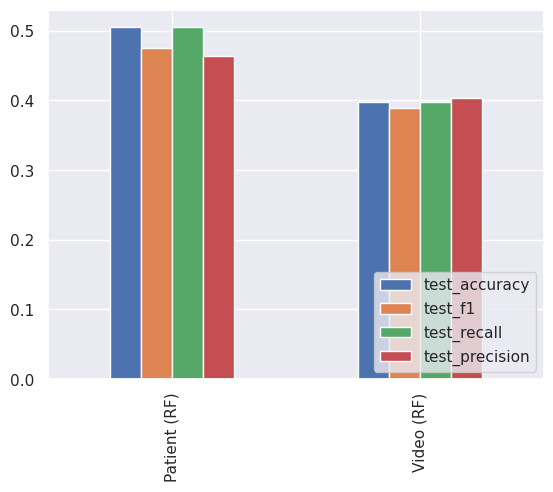

In [73]:
# summarize scores_mean and scores_mean_patient in one dataframe
# Add index level to df for aggregation
scores_mean = pd.concat([scores_mean], keys=["Video"], names=['Level'])
scores_mean_patient = pd.concat([scores_mean_patient], keys=["Patient"], names=['Level'])
# Concatenate
scores_mean = pd.concat([scores_mean, scores_mean_patient])

grouped = scores_mean.groupby("Level")
max_index = grouped["test_accuracy"].idxmax()
best_models = scores_mean.loc[max_index].sort_values("test_accuracy", ascending=False)
best_models.index = best_models.reset_index().Level + " (" + best_models.reset_index().model + ")"

best_models.plot.bar()
plt.legend(loc='lower right')

best_models.style.apply(highlight_max).format("{:.2f}")


In [74]:
# Do the same for the standard deviations
scores_std = pd.concat([scores_std], keys=["Video"], names=['Level'])
scores_std_patient = pd.concat([scores_std_patient], keys=["Patient"], names=['Level'])
scores_std = pd.concat([scores_std, scores_std_patient])

best_models_std = scores_std.loc[max_index]
best_models_std.index = best_models_std.reset_index().Level + " (" + best_models_std.reset_index().model + ")"
best_models_std = best_models_std.loc[best_models.index]


In [76]:
# Make latex
latex = best_models.applymap(lambda x: f"{x:.2f}") + " $_{\pm " + best_models_std.applymap(lambda x: f"{x:.2f}") + "}$"
# Drop accuracy
latex = latex.drop("test_accuracy", axis=1)
print(latex.to_latex(escape=False))

\begin{tabular}{llll}
\toprule
{} &             test_f1 &         test_recall &      test_precision \\
\midrule
Patient (RF) &  0.48 $_{\pm 0.09}$ &  0.51 $_{\pm 0.09}$ &  0.46 $_{\pm 0.11}$ \\
Video (RF)   &  0.39 $_{\pm 0.06}$ &  0.40 $_{\pm 0.06}$ &  0.40 $_{\pm 0.05}$ \\
\bottomrule
\end{tabular}

